In [37]:
import re
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn


from collections import Counter 

from tqdm.auto import tqdm

import textacy
import textacy.preprocessing as tprep

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords



from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import Phrases


from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer



import seaborn as sns
from sklearn.metrics import silhouette_score


# 1. Data Preprocessing

In [38]:
#read file
df = pd.read_csv('abstract_updated.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')]# remove the unnammed column
df.dropna(subset=['abstract'], inplace=True)
df

,study,abstract,year
0,"PIETERS S, 2018, J. Bus. Contin. Emerg. Plan.",THIS PAPER SHARES BEST PRACTICES FOR CRISIS MA...,2018.0
1,"F Z, 2017, PLOS ONE",SOCIAL MEDIA AGGREGATE PEOPLE AROUND COMMON IN...,2017.0
2,"LN P, 2019, Subst. USE Misuse",BACKGROUND: ADVANCES IN SOCIAL TECHNOLOGIES OF...,2019.0
3,"QW D, 2006, BIOINFORMATICS",MOTIVATION: REMOTE HOMOLOGY DETECTION BETWEEN ...,2006.0
4,"YANG M, 2019, Neural NETWORKS",TEXT CLASSIFICATION HAS BEEN ATTRACTING INCREA...,2019.0
...,...,...,...
4904,"WM K, 2023, BMJ OPEN",OBJECTIVE: THE PRESENT STUDY AIMED TO EARLY ID...,2023.0
4905,"C M, 2022, J BIOMED Inf.",OBJECTIVE: TO DEMONSTRATE HOW NON-NEGATIVE MAT...,2022.0
4906,"C P, 2023, RHEUMATOL THER",INTRODUCTION: THE SYMPTOMS ASSOCIATED WITH SJ\...,2023.0
4907,"Z K, 2022, Complement THER MED",BACKGROUND: QIGONG EMBRACES A RANGE OF SELF-CA...,2022.0


In [39]:
# make abstract sentence-case 
df['abstract']=df['abstract'].apply(str)
df['abstract']=df['abstract'].apply(lambda x: re.sub(r'\s\s+', ' ', x))#remove two whitespace
df['abstract']=df['abstract'].apply(lambda x: x.split(". "))    

df


,study,abstract,year
0,"PIETERS S, 2018, J. Bus. Contin. Emerg. Plan.",[THIS PAPER SHARES BEST PRACTICES FOR CRISIS M...,2018.0
1,"F Z, 2017, PLOS ONE",[SOCIAL MEDIA AGGREGATE PEOPLE AROUND COMMON I...,2017.0
2,"LN P, 2019, Subst. USE Misuse",[BACKGROUND: ADVANCES IN SOCIAL TECHNOLOGIES O...,2019.0
3,"QW D, 2006, BIOINFORMATICS",[MOTIVATION: REMOTE HOMOLOGY DETECTION BETWEEN...,2006.0
4,"YANG M, 2019, Neural NETWORKS",[TEXT CLASSIFICATION HAS BEEN ATTRACTING INCRE...,2019.0
...,...,...,...
4904,"WM K, 2023, BMJ OPEN",[OBJECTIVE: THE PRESENT STUDY AIMED TO EARLY I...,2023.0
4905,"C M, 2022, J BIOMED Inf.",[OBJECTIVE: TO DEMONSTRATE HOW NON-NEGATIVE MA...,2022.0
4906,"C P, 2023, RHEUMATOL THER",[INTRODUCTION: THE SYMPTOMS ASSOCIATED WITH SJ...,2023.0
4907,"Z K, 2022, Complement THER MED",[BACKGROUND: QIGONG EMBRACES A RANGE OF SELF-C...,2022.0


In [40]:
# function for removing punctuation-related stuff

def remove_punct_related(df):
    df['abstract'] = df['abstract'].apply(str)  # avoid error
    df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'\(.*?\)', '', x))  # remove anything like (C) for PsycInfo copyright
    df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'\.\.\.', '', x))  # remove anything like (...)
    df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'[^.\w\s]', '', x))  # remove other unwanted characters
    return df


def normalize(text):
    text = tprep.normalize.hyphenated_words(text)  # Normalize words in `text` that have been split across lines by a hyphen
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text



In [41]:
df = remove_punct_related(df)
df['abstract'] = df['abstract'].apply(lambda x: normalize(x))

df

,study,abstract,year
0,"PIETERS S, 2018, J. Bus. Contin. Emerg. Plan.",THIS PAPER SHARES BEST PRACTICES FOR CRISIS MA...,2018.0
1,"F Z, 2017, PLOS ONE",SOCIAL MEDIA AGGREGATE PEOPLE AROUND COMMON IN...,2017.0
2,"LN P, 2019, Subst. USE Misuse",BACKGROUND ADVANCES IN SOCIAL TECHNOLOGIES OFF...,2019.0
3,"QW D, 2006, BIOINFORMATICS",MOTIVATION REMOTE HOMOLOGY DETECTION BETWEEN P...,2006.0
4,"YANG M, 2019, Neural NETWORKS",TEXT CLASSIFICATION HAS BEEN ATTRACTING INCREA...,2019.0
...,...,...,...
4904,"WM K, 2023, BMJ OPEN",OBJECTIVE THE PRESENT STUDY AIMED TO EARLY IDE...,2023.0
4905,"C M, 2022, J BIOMED Inf.",OBJECTIVE TO DEMONSTRATE HOW NONNEGATIVE MATRI...,2022.0
4906,"C P, 2023, RHEUMATOL THER",INTRODUCTION THE SYMPTOMS ASSOCIATED WITH SJOG...,2023.0
4907,"Z K, 2022, Complement THER MED",BACKGROUND QIGONG EMBRACES A RANGE OF SELFCARE...,2022.0


# 2 spacy (pos)

In [42]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")
    
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

Working on GPU.


In [43]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]


def extract_nlp(doc):
    return {
#     'nouns'           : extract_lemmas(doc, include_pos = ['NOUN']),
    'nouns_plus_adjs' : extract_lemmas(doc, include_pos = ['ADJ','NOUN']),
    }

In [44]:
processed = df['abstract'].apply(lambda x: extract_nlp(nlp(x)))
nouns_plus_adjs = list(map(lambda x: x['nouns_plus_adjs'], processed))
df['nouns_plus_adjs'] = nouns_plus_adjs

df.head()


,study,abstract,year,nouns_plus_adjs
0,"PIETERS S, 2018, J. Bus. Contin. Emerg. Plan.",THIS PAPER SHARES BEST PRACTICES FOR CRISIS MA...,2018.0,"[shares, practice, adviser, approaches, collec..."
1,"F Z, 2017, PLOS ONE",SOCIAL MEDIA AGGREGATE PEOPLE AROUND COMMON IN...,2017.0,"[aggregate, common, interest, eliciting, frami..."
2,"LN P, 2019, Subst. USE Misuse",BACKGROUND ADVANCES IN SOCIAL TECHNOLOGIES OFF...,2019.0,"[tools, large, peer, networks, substance, mess..."
3,"QW D, 2006, BIOINFORMATICS",MOTIVATION REMOTE HOMOLOGY DETECTION BETWEEN P...,2006.0,"[protein, sequence, central, discriminative, e..."
4,"YANG M, 2019, Neural NETWORKS",TEXT CLASSIFICATION HAS BEEN ATTRACTING INCREA...,2019.0,"[classification, attention, growth, textual, d..."


# 3. Clustering

In [45]:
# https://www.markhneedham.com/blog/2015/02/12/pythongensim-creating-bigrams-over-how-i-met-your-mother-transcripts/
# https://github.com/pwharrison/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#training

bigram = Phrases(df['nouns_plus_adjs'], min_count=5, threshold=10)
trigram = Phrases(bigram[df['nouns_plus_adjs']], min_count=5, threshold=10)

In [46]:
# for trigram

df["temp"]=trigram[df['nouns_plus_adjs']]
df["temp"]=df["temp"].apply(lambda x: " ".join(x))

C:\Users\max19\anaconda3\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


## 3.1 replace phrases


In [47]:
df['temp']= df['temp'].apply(lambda x: re.sub(r'natural[_ ]language[_ ]processing', 'natural_language_processing', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'natural[_ ]language[_ ]processor', 'natural_language_processing', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'natural[_ ]language[_ ]process ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp-based ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlpt ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp[_ ]task ', 'natural_language_processing ', x))    
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp[_ ]technique ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp ', 'natural_language_processing ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'lda ', 'latent_dirichlet_allocation ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'latent[_ ]dirichlet[_ ]allocation_', 'latent_dirichlet_allocation ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'latent[_ ]dirichlet[_ ]allocation', 'latent_dirichlet_allocation', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'topic model', 'topic_modeling', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'topic modeling', 'topic_modeling', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'svm ', 'support_vector_machine ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' [^s][^u][^p][^p][^o][^r][^t][_ ]vector[_ ]machine ', ' support_vector_machine ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'support[_ ]vector[_ ]machine ', 'support_vector_machine ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'svms ', 'support_vector_machine ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'ehrs ', 'electronic_health_record ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'ehr ', 'electronic_health_record ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]healthcare[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]health[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]record', 'electronic_health_record', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'emrs ', 'electronic_health_record ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'emrs ', 'electronic_health_record ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]medical[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'medical[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'patient[_ ]record', 'electronic_health_record', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'liwc ', 'linguistic_inquiry_and_word_count ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'linguistic[_ ]inquiry[_ ]word[_ ]count', 'linguistic_inquiry_and_word_count', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'ai ', 'artificial_intelligence ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'cnn ', 'convolutional_neural_network ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'convolutional[_ ]neural[_ ]network', 'convolutional_neural_network', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'convolutional_network', 'convolutional_neural_network', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'lsa ', 'latent_semantic_analysis ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'latent_semantic analysis ', 'latent_semantic_analysis ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'latent_semantic ', 'latent_semantic_analysis ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' ml ', ' machine_learning ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' machine learning', ' machine_learning', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' supervised[_ ]machine[_ ]learning ', ' supervised_machine_learning ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' unsupervised[_ ]machine[_ ]learning ', ' unsupervised_machine_learning ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' asd ', ' autism_spectrum_disorder ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' autism ', ' autism_spectrum_disorder ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' autism[_ ]disorder', ' autism_spectrum_disorder', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' autistic[_ ]spectrum[_ ]disorder', ' autism_spectrum_disorder', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'coronavirus_disease', 'covid-19', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'coronavirus_disease', 'covid-19', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'covid-19_pandemic', 'covid-19', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'sentiment_lexicon classification', 'sentiment_classification', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' rf ', ' random_forest ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' qol ', ' quality_of_life ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'quality_life', 'quality_of_life', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'intervention_qol', ' quality_of_life', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'ugc ', 'user_generated_content ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'user_content', 'user_generated_content', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'user-generated[_ ]conten', 'user_generated_content', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'moocs ', 'massive_open_online_course ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'mooc ', 'massive_open_online_course ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'massive[_ ]open[_ ]online[_ ]course', 'massive_open_online_course', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' crf ', ' conditional_random_field ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'conditional[_ ]random[_ ]field', 'conditional_random_field', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' lstm ', ' long_short_term_memory ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' long[_ ]short[_ ]term[_ ]memory', ' long_short_term_memory', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' longshort[_ ]term[_ ]memory', ' long_short_term_memory', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'auc ', 'receiver_operating_characteristic ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'roc ', 'receiver_operating_characteristic ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'area[_ ]curve', 'receiver_operating_characteristic', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'area[_ ]receiver[_ ]operating[_ ]curve', 'receiver_operating_characteristic', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'area[_ ]receiver[_ ]operating[_ ]curve', 'receiver_operating_characteristic', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' receiver[_ ]characteristic[_ ]curve', ' receiver_operating_characteristic', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' ewom ', ' electronic_word_of_mouth ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' electronic[_ ]word[_ ]mouth', ' electronic_word_of_mouth', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'tweets ', 'twitter ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'tweet ', 'twitter ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'tweet[_ ]hashtag', 'twitter hashtag', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'api ', 'application_programming_interface ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'application[_ ]programming[_ ]interface', 'application_programming_interface', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'application[_ ]program[_ ]interface', 'application_programming_interface', x))
df['temp']

0       shares practice adviser approaches collecting ...
1       aggregate common interest eliciting framing di...
2       tools large peer networks substance message co...
3       protein sequence central discriminative effect...
4       classification attention growth textual_datum ...
                              ...                        
4904    present patient somatic care databased approac...
4905    demonstrate factorization topic large_collecti...
4906    patient limited IMPACT aimed understanding pat...
4907    qigong range exercise specific technique maint...
4908    clinical manifestation internal experience CAT...
Name: temp, Length: 4892, dtype: object

In [48]:
# # testing zone

# def count_words(df, column='tokens', preprocess=None, min_freq=2):

#     # preprocess tokens first (if the preprocess is defined) and update text for further analysis
#     def update(doc):
#         tokens = doc if preprocess is None else preprocess(doc)
#         counter.update(tokens)

#     # create counter and run through all data
#     counter = Counter()
#     df[column].map(update)# may be revised as map
#     #df[column].map(update)

#     # transform counter into data frame
#     freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
#     freq_df = freq_df.query('freq >= @min_freq')
#     freq_df.index.name = 'token'
    
#     return freq_df.sort_values('freq', ascending=False)


# # df['test2']=df['temp'].apply(lambda x: re.findall(r'natural[_ ]language[_ ][a-zA-Z]+',x))
# # df1=count_words(df, column='test2', preprocess=None, min_freq=2)
# # df1

# df['test2']=df['temp'].apply(lambda x: re.findall(r'[a-zA-Z]+[ ]knowledge[ ][a-zA-Z]+',x))
# # df['test2']=df['temp'].apply(lambda x: re.findall(r'[a-zA-Z]+[_][a-zA-Z]+[_][a-zA-Z]+[_][a-zA-Z]+',x))

# df1=count_words(df, column='test2', preprocess=None, min_freq=0)
# df1
# display(df1)

# # re.findall(r'[a-zA-Z]+_[a-zA-Z]+_*[a-zA-Z]*',df["test"][0])
# # df['test1'] = df['test'].apply(lambda x: re.findall(r'[a-zA-Z]+_[a-zA-Z]+_*[a-zA-Z]*',x))
# # df['test1']
# # df1=count_words(df, column='test1', preprocess=None, min_freq=2)
# # df1.to_excel("df_test.xlsx")

## 3.2 stopwords

In [49]:
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

included_stop_words = {'approach', 'datum', 'system','method', 'task', 'research', 'application','language','model','analysis',
                       'study','article','word','text','paper','result', 'people', 'use','finding', 'document','dataset',
                       'conclusion','method', 'result', 'introduction', 'issue', 'dicussion', 'problem', 'different', 'new',
                       'question', 'theory', 'work', 'time','processing' , 'process', 'high', 'information' ,
                       'human', 'tool' , 'technology','participant', 'natural_language', 'knowledge','individual', 'analyzed',
                       'background', 'objective' , 'important', "right"}
stopwords.update(included_stop_words)
stopwords_list = list(stopwords)


tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)

In [50]:
import csv
# Specify the filename
filename = "stopwords.csv"

# Writing the list to a CSV file
with open(filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    for word in stopwords_list:
        writer.writerow([word])

print(f"Stop words have been saved to {filename}.")

Stop words have been saved to stopwords.csv.


## 3.3 vectorization

In [51]:
trigram_tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['temp'])
trigram_tfidf_text_vectors

C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


<4892x4071 sparse matrix of type '<class 'numpy.float64'>'
	with 148853 stored elements in Compressed Sparse Row format>

## 3.4 number of cluster

C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default 

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

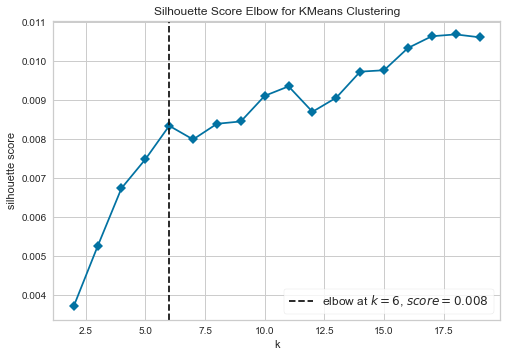

In [27]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 20), metric='silhouette', timings=False)
visualizer.fit(trigram_tfidf_text_vectors)       # Fit the data to the visualizer
visualizer.show(outpath="Kmeans_silhouette_coefficient.png") 

C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default 

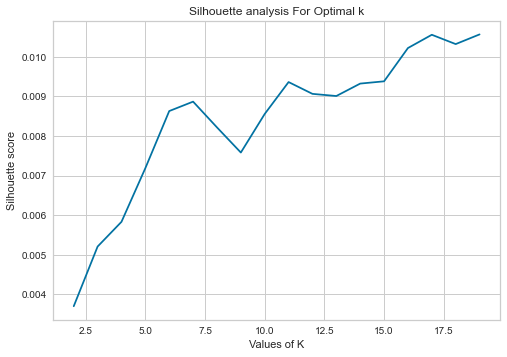

In [28]:
range_n_clusters = np.arange(2,20)
silhouette_avg = []
for num_clusters in range_n_clusters:

    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(trigram_tfidf_text_vectors)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(trigram_tfidf_text_vectors, cluster_labels))
    
    

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

## 3.5 kmeans

In [52]:
number_of_cluster = 6

k_means_para = KMeans(n_clusters=number_of_cluster, random_state=42)
k_means_para.fit(trigram_tfidf_text_vectors)
df['cluster'] = k_means_para.labels_


C:\Users\max19\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


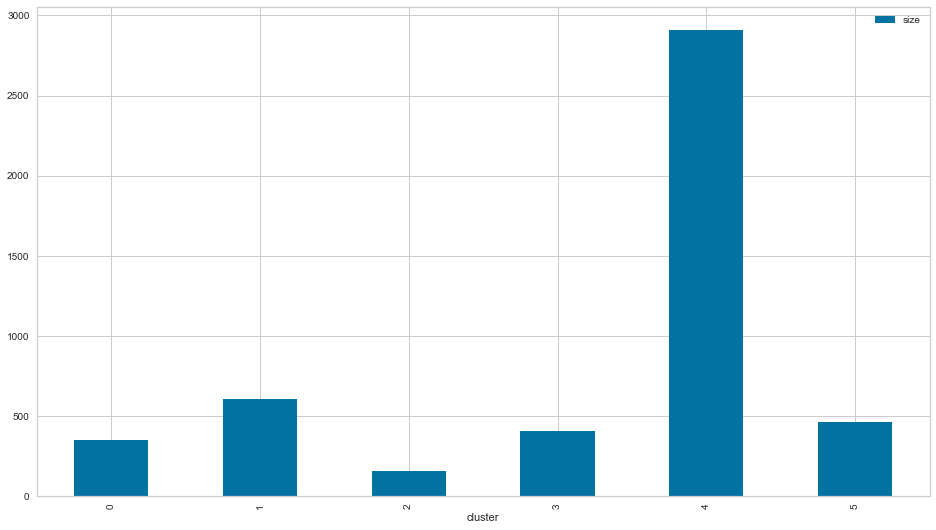

In [53]:
sizes = []
for i in range(number_of_cluster):
    sizes.append({"cluster": i, "size": np.sum(k_means_para.labels_ == i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))
plt.savefig("cluster-size.svg")

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the stopwords_list to a set, which is required by WordCloud
stopwords_set = set(stopwords_list)

# Function to generate and save word cloud
def generate_word_cloud(text, title, filename):
    wordcloud = WordCloud(width=1200, height=800, background_color='white', stopwords=stopwords_set).generate(text)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(filename, format='png')
    plt.close()  # Close the plot to free memory

# Assuming df is your DataFrame and 'cluster' and 'temp' columns exist
for i in range(number_of_cluster):
    # Filter rows for the current cluster
    cluster_data = df[df['cluster'] == i]
    
    # Combine all text in the 'temp' column for this cluster
    combined_text = ' '.join(cluster_data['temp'].explode())
    
    # Generate and save word cloud for this cluster
    filename = f'word_cloud_cluster_{i}.png'
    generate_word_cloud(combined_text, title=f'Word Cloud for Cluster {i}', filename=filename)
    print(f'Saved word cloud for cluster {i} as {filename}')


Saved word cloud for cluster 0 as word_cloud_cluster_0.png
Saved word cloud for cluster 1 as word_cloud_cluster_1.png
Saved word cloud for cluster 2 as word_cloud_cluster_2.png
Saved word cloud for cluster 3 as word_cloud_cluster_3.png
Saved word cloud for cluster 4 as word_cloud_cluster_4.png
Saved word cloud for cluster 5 as word_cloud_cluster_5.png


In [55]:
df["cluster"]=k_means_para.labels_
df.head()
df.to_excel("df_cluster.xlsx")

In [21]:
df.head()

,study,abstract,nouns_plus_adjs,temp,cluster
0,"PIETERS S, 2018, J. Bus. Contin. Emerg. Plan.",THIS PAPER SHARES BEST PRACTICES FOR CRISIS MA...,"[paper, shares, practice, adviser, approaches,...",paper shares practice adviser approaches colle...,0
1,"F Z, 2017, PLOS ONE",SOCIAL MEDIA AGGREGATE PEOPLE AROUND COMMON IN...,"[aggregate, PEOPLE, common, interest, elicitin...",aggregate PEOPLE common interest eliciting fra...,0
2,"LN P, 2019, Subst. USE Misuse",BACKGROUND ADVANCES IN SOCIAL TECHNOLOGIES OFF...,"[new, tools, large, analysis, peer, networks, ...",new tools large analysis peer networks substan...,0
3,"QW D, 2006, BIOINFORMATICS",MOTIVATION REMOTE HOMOLOGY DETECTION BETWEEN P...,"[protein, sequence, central, problem, discrimi...",protein sequence central problem discriminativ...,1
4,"YANG M, 2019, Neural NETWORKS",TEXT CLASSIFICATION HAS BEEN ATTRACTING INCREA...,"[text, classification, attention, growth, text...",text_classification attention growth textual_d...,1


In [87]:
print("Stopwords:", stopwords_list)


Stopwords: ['‘d', 'back', 'therein', 'knowledge', 'as', 'different', 'move', 'amongst', 'make', 'nobody', "'re", 'approach', 'within', 'was', 'whose', 'than', 'everything', 'text', 'always', 'nothing', 'thence', 'i', 'until', 'thereupon', '’ve', 'thus', 'so', 'name', 'since', 'although', 'ours', '‘ll', 'thereafter', 'do', 'any', '’re', 'per', 'either', 'each', 'much', 'must', 'does', 'therefore', 'processing', 'though', 'she', 'put', 'against', 'sometime', 'had', 'more', 'whatever', 'hers', 'their', 'over', 'take', 'get', 'least', '’m', 'word', 'yourself', '‘m', 'here', 'information', 'call', 'theory', 'article', 'a', 'out', 'thereby', 'whereafter', 'yet', 'say', 'whether', 'somewhere', 'someone', 'namely', 'cannot', '’s', 'every', 'less', 'question', 'by', 'while', 'some', 'result', "'s", 'before', 'indeed', 'my', 'bottom', 'seems', 'upon', 'am', 'none', 'done', 'latter', 'together', 'because', 'introduction', 'there', 'wherever', '’ll', 'really', 'something', 'five', 'your', 'languag